In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from ydata_profiling import ProfileReport
import sys
from pathlib import Path
# add project root (project/ is the parent of notebooks/)
project_root = Path.cwd().parent
sys.path.append(str(project_root))
print("Project root added to PYTHONPATH:", project_root)
from src.data.load import load_raw_data

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", None)

#read config file
config_path = "../configs/base.yaml"
with open(config_path,"r") as f:
    config = yaml.safe_load(f)

data_path = Path(config["combined_data_path"])
target_col = config["target"]

print(f"Config loaded successfully!")
print(f"Data path: {data_path}")
print(f"Target column:{target_col}")

#3. Load data
df = load_raw_data(str(data_path))
print(f"Data loaded successfully! Shape = {df.shape}")
df.head()

Project root added to PYTHONPATH: /Users/april/Documents/Project/wind_forecast_project
Config loaded successfully!
Data path: ../data/processed/gefcom_wind_all_zones.csv
Target column:target
Data loaded successfully! Shape = (168000, 7)


,zone_id,datetime,target,U10,V10,U100,V100
0,1,2012-01-01 01:00:00,0.000000,2.124600,-2.681966,2.864280,-3.666076
1,1,2012-01-01 02:00:00,0.054879,2.521695,-1.796960,3.344859,-2.464761
2,1,2012-01-01 03:00:00,0.110234,2.672210,-0.822516,3.508448,-1.214093
3,1,2012-01-01 04:00:00,0.165116,2.457504,-0.143642,3.215233,-0.355546
4,1,2012-01-01 05:00:00,0.156940,2.245898,0.389576,2.957678,0.332701


In [5]:
print("\n Data type and missing information:")
print(df.info())

print("\n Descriptive statistics:")
display(df.describe().T)

print("\n missing value statistics:")
print(df.isna().sum())


 Data type and missing information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168000 entries, 0 to 167999
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   zone_id   168000 non-null  int64         
 1   datetime  168000 non-null  datetime64[ns]
 2   target    167888 non-null  float64       
 3   U10       168000 non-null  float64       
 4   V10       168000 non-null  float64       
 5   U100      168000 non-null  float64       
 6   V100      168000 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 9.0 MB
None

 Descriptive statistics:


,count,mean,min,25%,50%,75%,max,std
zone_id,168000.0,5.5,1.0,3.0,5.5,8.0,10.0,2.87229
datetime,168000,2012-12-16 00:30:00,2012-01-01 01:00:00,2012-06-24 00:45:00,2012-12-16 00:30:00,2013-06-09 00:15:00,2013-12-01 00:00:00,NaN
target,167888.0,0.36048,0.0,0.081003,0.281302,0.606016,1.0,0.310831
U10,168000.0,0.818764,-8.371644,-1.501748,0.54512,2.805488,14.837177,3.034753
V10,168000.0,0.089091,-12.923576,-2.158184,0.363812,2.34191,11.401396,3.116356
U100,168000.0,1.282886,-12.425352,-2.410327,1.05605,4.753575,21.399071,4.823644
V100,168000.0,0.009308,-19.791997,-3.864192,0.709303,4.072244,16.304799,5.113098



 missing value statistics:
zone_id       0
datetime      0
target      112
U10           0
V10           0
U100          0
V100          0
dtype: int64


In [6]:
#basic sanity and per-zone continuity
print(df.dtypes)
print("Unique zones:", df["zone_id"].nunique(), sorted(df["zone_id"].unique().tolist()))
#sort and check hourly gaps
df = df.sort_values(["zone_id", "datetime"]).reset_index(drop=True)
gaps = (df.groupby("zone_id")["datetime"]
          .diff().dt.total_seconds().div(3600)
        .fillna(1))
print("Share of non-1h steps:", (gaps != 1).mean())


zone_id              int64
datetime    datetime64[ns]
target             float64
U10                float64
V10                float64
U100               float64
V100               float64
dtype: object
Unique zones: 10 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Share of non-1h steps: 0.0


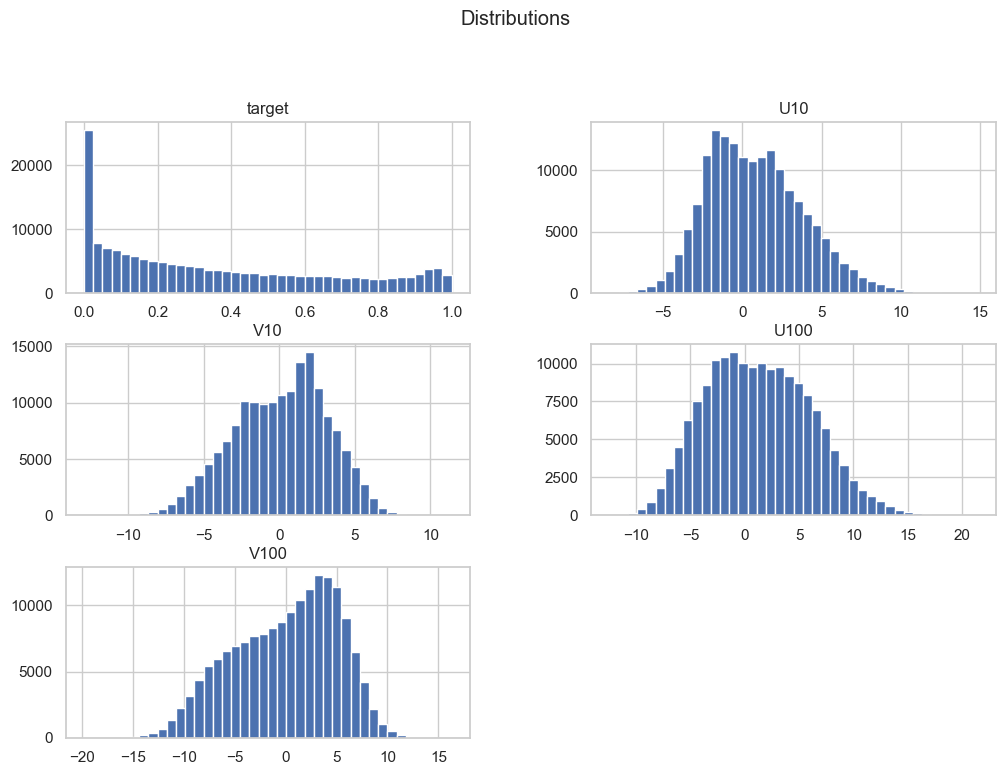

,count,mean,std,min,25%,50%,75%,max
target,167888.0,0.360480,0.310831,0.000000,0.081003,0.281302,0.606016,1.000000
U10,168000.0,0.818764,3.034753,-8.371644,-1.501748,0.545120,2.805488,14.837177
V10,168000.0,0.089091,3.116356,-12.923576,-2.158184,0.363812,2.341910,11.401396
U100,168000.0,1.282886,4.823644,-12.425352,-2.410327,1.056050,4.753575,21.399071
V100,168000.0,0.009308,5.113098,-19.791997,-3.864192,0.709303,4.072244,16.304799


In [7]:
#distributions(target & winds)
num_cols = [target_col, "U10", "V10", "U100", "V100"]
ax = df[num_cols].hist(bins=40, figsize=(12,8))
plt.suptitle("Distributions", y=1.02)
plt.show()

df[num_cols].describe().T

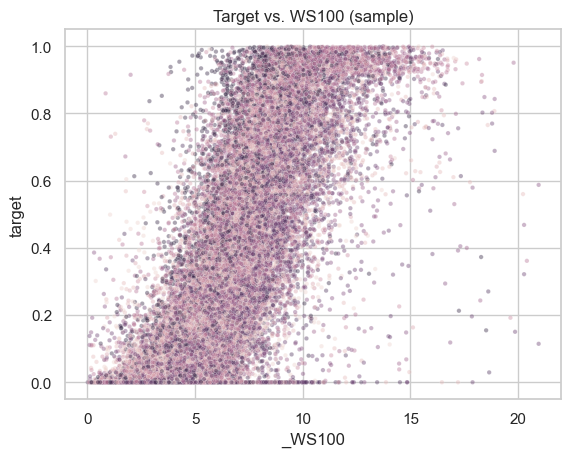

,_WS10,_WS100,target
_WS10,1.000000,0.917451,0.711410
_WS100,0.917451,1.000000,0.764711
target,0.711410,0.764711,1.000000


In [8]:
#temporary analysis features
df["_WS10"] = np.hypot(df["U10"], df["V10"])
df["_WS100"] = np.hypot(df["U100"], df["V100"])

sns.scatterplot(data=df.sample(min(len(df), 30000), random_state = 0),
                x="_WS100", y=target_col, hue="zone_id", s=10, alpha=0.4, legend=False)
plt.title("Target vs. WS100 (sample)")
plt.show()

df[["_WS10", "_WS100", target_col]].corr(numeric_only=True)

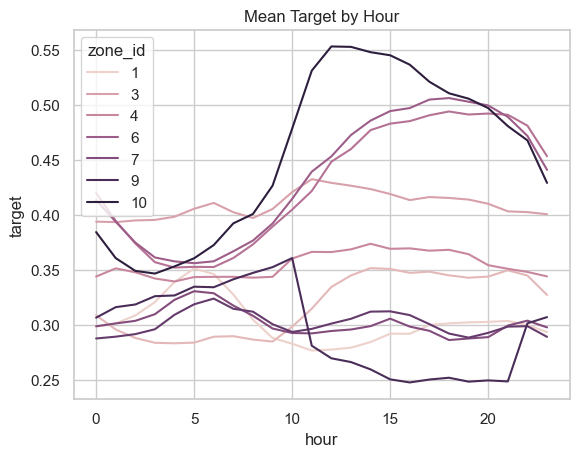

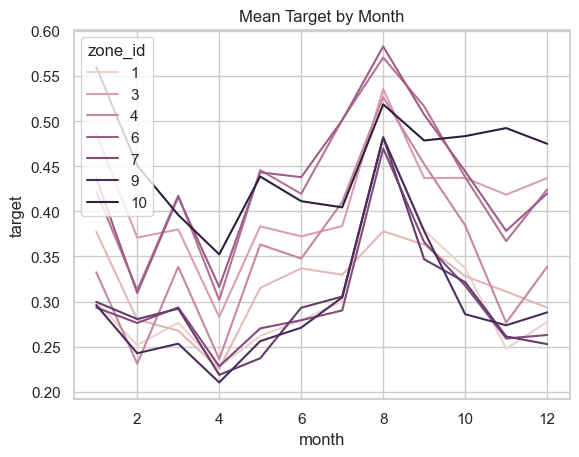

In [9]:
#seasonality(hour/month)
tmp = df.assign(
    hour=df["datetime"].dt.hour,
    month=df["datetime"].dt.month
)

hourly = tmp.groupby(["zone_id", "hour"])[target_col].mean().reset_index()
sns.lineplot(data=hourly, x="hour", y=target_col, hue="zone_id")
plt.title("Mean Target by Hour")
plt.show()

monthly = tmp.groupby(["zone_id", "month"])[target_col].mean().reset_index()
sns.lineplot(data=monthly, x="month", y=target_col, hue="zone_id")
plt.title("Mean Target by Month")
plt.show()

In [10]:
#missing rates
miss = df.isna().mean().sort_values(ascending=False)
print("Missing rate:\n", miss)

#IQR outlier flag
def iqr_outlier(s, k=1.5):
    q1, q3 = s.quantile([0.25, 0.75]) 
    iqr = q3 - q1
    return(s < q1 - k*iqr) | (s > q3 + k*iqr)

out_cols = [target_col, "_WS10", "_WS100", "U10", "V10", "U100", "V100"]
flags = {c: iqr_outlier(df[c].dropna()) for c in out_cols if df[c].dtype!="O"}
print({c: int(flags[c].sum()) for c in flags})                          

Missing rate:
 target      0.000667
zone_id     0.000000
datetime    0.000000
U10         0.000000
V10         0.000000
U100        0.000000
V100        0.000000
_WS10       0.000000
_WS100      0.000000
dtype: float64
{'target': 0, '_WS10': 2157, '_WS100': 2574, 'U10': 1019, 'V10': 269, 'U100': 346, 'V100': 42}


In [ ]:
# Nothing executed here — notes for FE:
# - All rolling stats must be computed AFTER a shift(1) within each ZONEID.
# - Train/val/test must be split by time BEFORE model fitting.
# - TIMESTAMP should NOT be fed directly to LightGBM; instead use sine/cosine or drop it.
pass

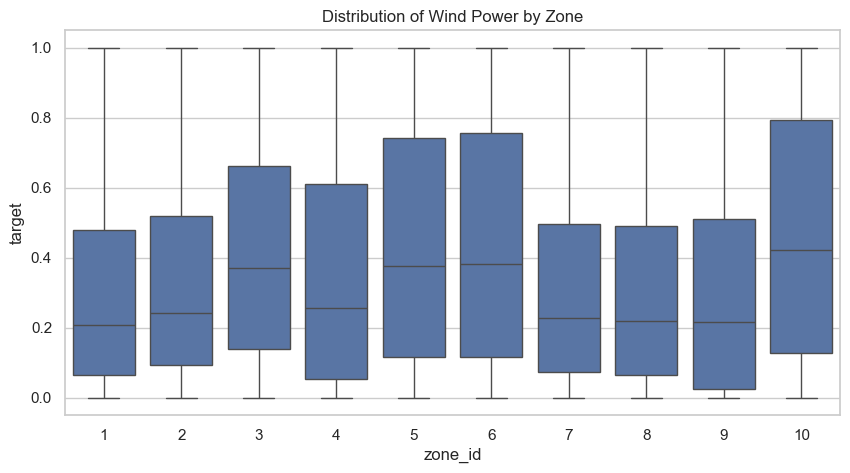

In [11]:
#zone distribution
plt.figure(figsize=(10, 5))
sns.boxplot(x="zone_id", y=target_col, data=df)
plt.title("Distribution of Wind Power by Zone")
plt.show()

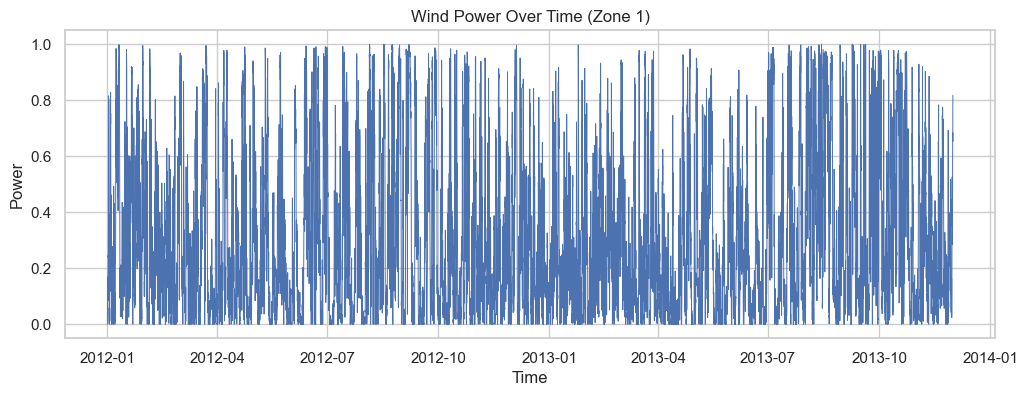

In [13]:
#time trend(zone 1)
zone_1 = df[df["zone_id"] == 1]
plt.figure(figsize=(12,4))
plt.plot(zone_1["datetime"], zone_1[target_col], linewidth=0.7)
plt.title("Wind Power Over Time (Zone 1)")
plt.xlabel("Time")
plt.ylabel("Power")
plt.show()

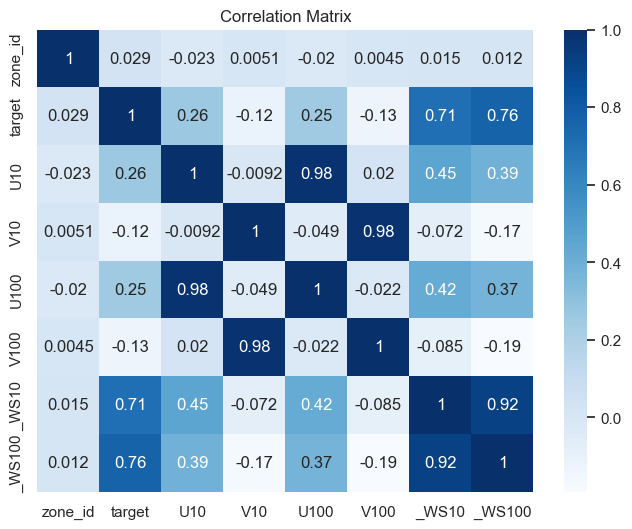

In [14]:
#correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="Blues")
plt.title("Correlation Matrix")
plt.show()